In [1]:
# Setup (PyTorch, paths, device, seeds)
import os, random, math, time
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms ,models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import tempfile

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_fscore_support
torch.manual_seed(42)

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# Use the returned path to set base_dir correctly
base_dir = os.path.join(path, "chest_xray")
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

In [3]:
print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)

print("Train dir contents:", os.listdir(train_dir))
print("Val dir contents:", os.listdir(val_dir))
print("Test dir contents:", os.listdir(test_dir))

Train dir: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Val dir: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Test dir: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Train dir contents: ['PNEUMONIA', 'NORMAL']
Val dir contents: ['PNEUMONIA', 'NORMAL']
Test dir contents: ['PNEUMONIA', 'NORMAL']


In [4]:
# Print image counts before shuffle/split
print('Before split:')
for split in ['train', 'val']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(base_dir, split, cls)
        print(f"{split}/{cls}: {len(os.listdir(folder))}")

# Combine all images from train and val only (do not touch test)
all_data = []
for split in ['train', 'val']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(base_dir, split, cls)
        for fname in os.listdir(folder):
            all_data.append((os.path.join(folder, fname), cls))

# Stratified split: 85% train, 15% val
paths, labels = zip(*all_data)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.15, stratify=labels, random_state=42)

def copy_files(file_paths, labels, dest_dir):
    for path, label in zip(file_paths, labels):
        dest = os.path.join(dest_dir, label)
        os.makedirs(dest, exist_ok=True)
        shutil.copy(path, dest)

# Set your new base_dir for split (must be writable, e.g., /kaggle/working or local path)
# Use /kaggle/working if running on Kaggle, or a local writable path otherwise

# Use a writable temp directory for the split
new_base = os.path.join(tempfile.gettempdir(), "chest_xray_split")
copy_files(train_paths, train_labels, os.path.join(new_base, 'train'))
copy_files(val_paths, val_labels, os.path.join(new_base, 'val'))

# Print image counts after shuffle/split
print('After split:')
for split in ['train', 'val']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(new_base, split, cls)
        print(f"{split}/{cls}: {len(os.listdir(folder))}")

# Update directory variables to point to the new split
train_dir = os.path.join(new_base, 'train')
val_dir   = os.path.join(new_base, 'val')
# test_dir remains unchanged

Before split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8
After split:
train/NORMAL: 1147
train/PNEUMONIA: 3300
val/NORMAL: 202
val/PNEUMONIA: 583


In [5]:
# Datasets, DataLoaders, class weights (for imbalance)
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 4

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

train_ds = datasets.ImageFolder(train_dir, transform=transform)
val_ds   = datasets.ImageFolder(val_dir,   transform=transform)
test_ds  = datasets.ImageFolder(test_dir,  transform=transform)

print("Classes:", train_ds.classes, "=>", train_ds.class_to_idx)

Classes: ['NORMAL', 'PNEUMONIA'] => {'NORMAL': 0, 'PNEUMONIA': 1}


In [6]:
# CNN model as a class (__init__ + forward)
class PneumoCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(PneumoCNN, self).__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        m = models.resnet18(weights=weights)
        m.fc = nn.Linear(m.fc.in_features, 1)
        self.net = m

    def forward(self, x):
        return self.net(x).squeeze(1)  # [B]

In [7]:
model = PneumoCNN(num_classes=1)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


PneumoCNN(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)
model = model.to(device)
EPOCHS = 15
patience = int(EPOCHS * 2/3)
lr = 1e-3

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

device:  cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
# Compute class weights for BCEWithLogitsLoss (pos_weight = N_neg / N_pos for label=1 class)
# In ImageFolder, NORMAL -> 0, PNEUMONIA -> 1 (alphabetical)
train_targets = torch.tensor([y for _, y in train_ds.samples])
pos = (train_targets==1).sum().item()
neg = (train_targets==0).sum().item()
pos_weight = torch.tensor([neg / max(pos,1.0)], dtype=torch.float32)
print(f"Train counts -> NEG(NORMAL)={neg}, POS(PNEUMONIA)={pos}, pos_weight={pos_weight.item():.3f}")

Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


In [10]:
# # Loss, Optimizer, LR scheduler
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))  # robust for class imbalance
optimizer = AdamW(model.parameters(), lr=lr)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True) # monitors val accuracy

In [11]:
# Utilities: train/eval loops
def accuracy_from_logits(logits, targets):
    probs = torch.sigmoid(logits).squeeze(1)
    preds = (probs >= 0.5).long()
    correct = (preds == targets.long()).sum().item()
    return correct, preds, probs

def run_one_epoch(model, loader, epochNumber, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    epoch_loss = 0.0
    correct = 0
    n = 0
    all_probs, all_targets = [], []

    for images, targets in tqdm(loader, desc=f"Epoch {epochNumber}/{EPOCHS}"):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.set_grad_enabled(is_train):
            logits  = model(images)
            if logits.ndim == 2 and logits.size(1) == 1:
                logits = logits[:, 0]
            targets = targets.float().view(-1)
            loss = criterion(logits, targets)
            if is_train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

        c, _, probs = accuracy_from_logits(logits.unsqueeze(1), targets)
        epoch_loss += loss.item() * images.size(0)
        correct += c
        n += images.size(0)

        all_probs.append(probs.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = epoch_loss / n
    acc = correct / n
    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # Some environments may lack enough positive/negative samples for AUC early on; guard it
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except Exception:
        auc = float('nan')

    return avg_loss, acc, auc, all_probs, all_targets

In [12]:
# CTraining over epochs with early stopping + checkpoint
best_val_acc = -np.inf
no_improve = 0
ckpt_path = "best_cnn_pneumonia.pt"

history = {"train_loss":[], "train_acc":[], "train_auc":[],
           "val_loss":[], "val_acc":[], "val_auc":[]}

start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_auc, _, _ = run_one_epoch(model, train_loader, epoch, optimizer)
    va_loss, va_acc, va_auc, _, _ = run_one_epoch(model, val_loader, epoch, optimizer=None)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc); history["train_auc"].append(tr_auc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc);   history["val_auc"].append(va_auc)

    # scheduler.step(va_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train: loss {tr_loss:.4f} acc {tr_acc:.4f} auc {tr_auc:.4f} | "
          f"Val:   loss {va_loss:.4f} acc {va_acc:.4f} auc {va_auc:.4f}")

    # Early stopping & checkpoint
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        no_improve = 0
        torch.save({"model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "epoch": epoch}, ckpt_path)
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

print(f"Training finished in {(time.time()-start)/60:.1f} min. Best val acc: {best_val_acc:.4f}")

Epoch 1/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/15: 100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


Epoch 01/15 | Train: loss 0.0809 acc 0.9337 auc 0.9849 | Val:   loss 0.0394 acc 0.9682 auc 0.9968


Epoch 2/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warni

Epoch 02/15 | Train: loss 0.0440 acc 0.9665 auc 0.9951 | Val:   loss 0.1231 acc 0.8815 auc 0.9969


Epoch 3/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warni

Epoch 03/15 | Train: loss 0.0439 acc 0.9681 auc 0.9953 | Val:   loss 0.0736 acc 0.9274 auc 0.9976


Epoch 4/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warni

Epoch 04/15 | Train: loss 0.0322 acc 0.9748 auc 0.9971 | Val:   loss 0.0342 acc 0.9618 auc 0.9982


Epoch 5/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warni

Epoch 05/15 | Train: loss 0.0375 acc 0.9710 auc 0.9966 | Val:   loss 0.0553 acc 0.9529 auc 0.9935


Epoch 6/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warni

Epoch 06/15 | Train: loss 0.0347 acc 0.9750 auc 0.9968 | Val:   loss 0.0546 acc 0.9732 auc 0.9983


Epoch 7/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warni

Epoch 07/15 | Train: loss 0.0312 acc 0.9775 auc 0.9976 | Val:   loss 0.0329 acc 0.9745 auc 0.9976


Epoch 8/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warni

Epoch 08/15 | Train: loss 0.0256 acc 0.9804 auc 0.9984 | Val:   loss 0.1490 acc 0.9452 auc 0.9965


Epoch 9/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warni

Epoch 09/15 | Train: loss 0.0284 acc 0.9782 auc 0.9979 | Val:   loss 0.0461 acc 0.9439 auc 0.9985


Epoch 10/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  war

Epoch 10/15 | Train: loss 0.0248 acc 0.9809 auc 0.9983 | Val:   loss 0.0412 acc 0.9669 auc 0.9964


Epoch 11/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  war

Epoch 11/15 | Train: loss 0.0281 acc 0.9802 auc 0.9980 | Val:   loss 0.0261 acc 0.9847 auc 0.9985


Epoch 12/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  war

Epoch 12/15 | Train: loss 0.0234 acc 0.9827 auc 0.9985 | Val:   loss 0.0395 acc 0.9682 auc 0.9977


Epoch 13/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  war

Epoch 13/15 | Train: loss 0.0187 acc 0.9861 auc 0.9991 | Val:   loss 0.0788 acc 0.9694 auc 0.9981


Epoch 14/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  war

Epoch 14/15 | Train: loss 0.0229 acc 0.9807 auc 0.9988 | Val:   loss 0.0329 acc 0.9783 auc 0.9975


Epoch 15/15:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  war

Epoch 15/15 | Train: loss 0.0250 acc 0.9818 auc 0.9984 | Val:   loss 0.0611 acc 0.9707 auc 0.9976
Training finished in 21.6 min. Best val acc: 0.9847


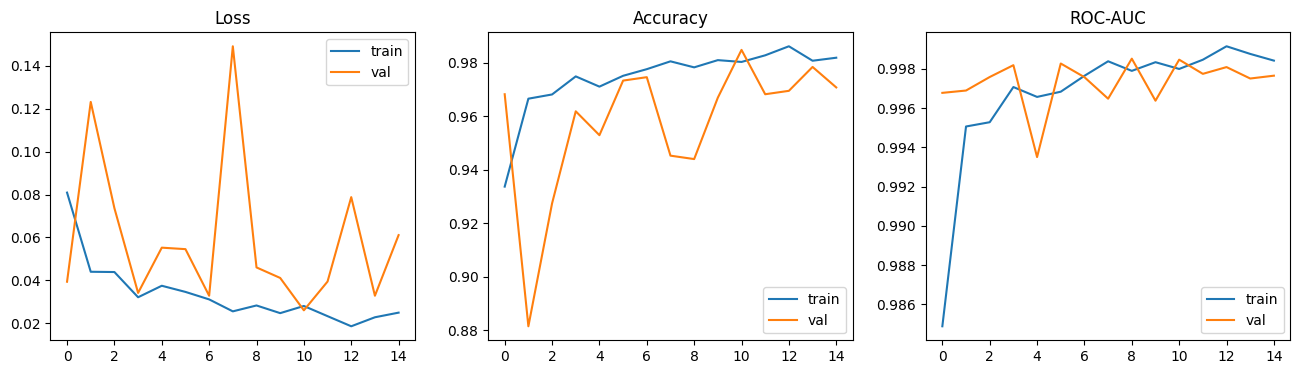

In [13]:
# Load best checkpoint (optional) and plot curves
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])

def plot_curves(h):
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs[0].plot(h["train_loss"], label="train"); axs[0].plot(h["val_loss"], label="val")
    axs[0].set_title("Loss"); axs[0].legend()
    axs[1].plot(h["train_acc"], label="train"); axs[1].plot(h["val_acc"], label="val")
    axs[1].set_title("Accuracy"); axs[1].legend()
    axs[2].plot(h["train_auc"], label="train"); axs[2].plot(h["val_auc"], label="val")
    axs[2].set_title("ROC-AUC"); axs[2].legend()
    plt.show()

plot_curves(history)

Epoch 1/15:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/15: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

test pres (first 10): [0.01177473 0.06346016 0.67115945 0.1181073  0.0028984  0.00697887
 0.19570495 0.03608383 0.90575504 0.51232105]
TEST — loss: 0.6012 | acc: 0.8590 | auc: 0.9683
Confusion Matrix:
 [[148  86]
 [  2 388]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.9867    0.6325    0.7708       234
   PNEUMONIA     0.8186    0.9949    0.8981       390

    accuracy                         0.8590       624
   macro avg     0.9026    0.8137    0.8345       624
weighted avg     0.8816    0.8590    0.8504       624



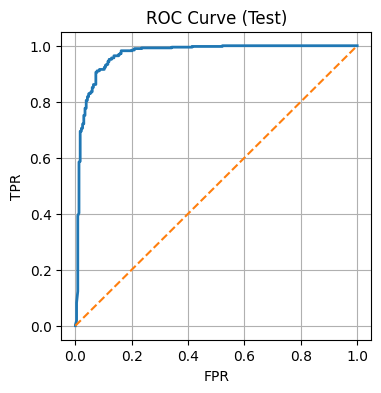

In [14]:
# Final test evaluation + confusion matrix, precision/recall/F1
test_loss, test_acc, test_auc, probs, targets = run_one_epoch(model, test_loader, 1, optimizer=None)
print(f"test pres (first 10): {probs[:10]}")
## TODO: consider using a threshold other than 0.5
preds = (probs >= 0.5).astype(int)

print(f"TEST — loss: {test_loss:.4f} | acc: {test_acc:.4f} | auc: {test_auc:.4f}")

cm = confusion_matrix(targets, preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n",
      classification_report(targets, preds, target_names=test_ds.classes, digits=4))

# Quick ROC curve
fpr, tpr, _ = roc_curve(targets, probs)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve (Test)')
plt.grid(True); plt.show()

In [15]:
# Inference helper (predict on a few samples)
from PIL import Image

def predict_image(path, model, tfms=transform):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logit = model(x)
        prob = torch.sigmoid(logit).item()
    pred = int(prob >= 0.5)
    return prob, pred  # probability of PNEUMONIA, predicted label (0 normal / 1 pneumonia)

# Example:
# p, yhat = predict_image(os.path.join(test_dir, "PNEUMONIA", os.listdir(os.path.join(test_dir,"PNEUMONIA"))[0]), model)
# print(p, yhat)


In [16]:
# TODO: consider adding Visualizations like the R3